In [1]:
import findspark
findspark.init()

from pyspark import SparkContext
sc = SparkContext()

from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("Mini-Project").getOrCreate()

In [2]:
from pyspark.sql.types import *
from pyspark.sql.functions import col
import pandas as pd
import numpy as np
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.feature import HashingTF, IDF, Tokenizer, CountVectorizer, StopWordsRemover
from pyspark.ml.clustering import KMeans
from pyspark.ml import Pipeline
from matplotlib import pyplot as plt

In [3]:
rc = spark.read.format('json').load('s3://jk2060/final_project')

In [4]:
rc.take(5)

[Row(archived=None, author='[deleted]', author_cakeday=None, author_created_utc=None, author_flair_background_color='', author_flair_css_class=None, author_flair_richtext=None, author_flair_template_id=None, author_flair_text=None, author_flair_text_color='dark', author_flair_type=None, author_fullname=None, author_patreon_flair=None, body='[deleted]', can_gild=True, can_mod_post=False, collapsed=True, collapsed_reason=None, controversiality=0, created_utc=1550448000, distinguished=None, edited='false', gilded=0, gildings=Row(gid_1=0, gid_2=0, gid_3=0), id='egp0iaf', is_submitter=False, link_id='t3_arqt23', no_follow=True, parent_id='t3_arqt23', permalink='/r/teenagersnew/comments/arqt23/nothing_better_than_some_french_songs/egp0iaf/', quarantined=False, removal_reason=None, retrieved_on=1554361170, score=1, send_replies=True, stickied=False, subreddit='teenagersnew', subreddit_id='t5_hcxiu', subreddit_name_prefixed='r/teenagersnew', subreddit_type='public'),
 Row(archived=None, author

In [5]:
rc.cache()

DataFrame[archived: boolean, author: string, author_cakeday: boolean, author_created_utc: bigint, author_flair_background_color: string, author_flair_css_class: string, author_flair_richtext: array<struct<a:string,e:string,t:string,u:string>>, author_flair_template_id: string, author_flair_text: string, author_flair_text_color: string, author_flair_type: string, author_fullname: string, author_patreon_flair: boolean, body: string, can_gild: boolean, can_mod_post: boolean, collapsed: boolean, collapsed_reason: string, controversiality: bigint, created_utc: bigint, distinguished: string, edited: string, gilded: bigint, gildings: struct<gid_1:bigint,gid_2:bigint,gid_3:bigint>, id: string, is_submitter: boolean, link_id: string, no_follow: boolean, parent_id: string, permalink: string, quarantined: boolean, removal_reason: string, retrieved_on: bigint, score: bigint, send_replies: boolean, stickied: boolean, subreddit: string, subreddit_id: string, subreddit_name_prefixed: string, subreddi

In [6]:
#remove the deleted comments from the dataset
rc = rc.filter("body != '[deleted]'")

In [10]:
rc.rdd \
    .map(lambda comment: ('key', 1)) \
    .reduceByKey(lambda accum, n: accum + n) \
    .collect()

[('key', 29273619)]

In [11]:
rc.createOrReplaceTempView('rc')

In [12]:
#sort subreddit type
subreddit_counts = spark.sql("\
SELECT subreddit, COUNT(*) as count \
FROM rc \
GROUP BY subreddit \
ORDER BY count DESC \
LIMIT 10")

In [13]:
spark.sql("\
SELECT subreddit, COUNT(*) as count \
FROM rc \
GROUP BY subreddit \
ORDER BY count DESC").show()

+--------------------+-------+
|           subreddit|  count|
+--------------------+-------+
|           AskReddit|1433433|
|            politics| 504507|
|         apexlegends| 281622|
|               memes| 272613|
|           dankmemes| 262786|
|                 nba| 262240|
|               funny| 247514|
|          The_Donald| 214529|
|       AnthemTheGame| 208098|
|           teenagers| 206026|
|              gaming| 195985|
|    unpopularopinion| 181864|
|            AskOuija| 178997|
|              soccer| 175285|
|           worldnews| 167763|
|       SquaredCircle| 166623|
|PewdiepieSubmissions| 164727|
|                pics| 159879|
|          FortNiteBR| 158387|
|                news| 155126|
+--------------------+-------+
only showing top 20 rows



In [16]:
spark.conf.set("spark.sql.execution.arrow.enabled", "false")
subreddit_counts_pd = subreddit_counts.select("*").toPandas()

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

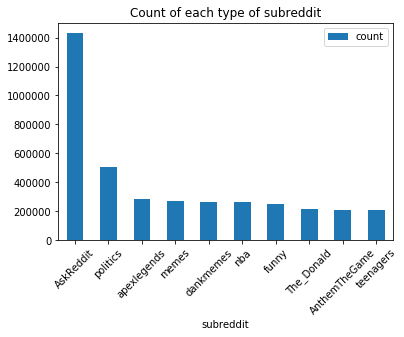

In [17]:
#plot the subreddit type ranking
subreddit_counts_pd.plot(kind='bar',x='subreddit',y='count')
plt.title('Count of each type of subreddit')
plt.xticks(rotation=45)

In [18]:
spark.sql("\
SELECT author, SUM(gilded) as gild_received \
FROM rc \
WHERE author != '[deleted]' \
GROUP BY author \
ORDER BY gild_received DESC").show()

+-------------------+-------------+
|             author|gild_received|
+-------------------+-------------+
|  TheBirminghamBear|           36|
|       Mattwatson07|           35|
|  SchnoodleDoodleDo|           33|
|    TooShiftyForYou|           17|
|          _demetri_|           15|
|SerAmantiodiNicolao|           12|
|     baconistheking|           12|
|        PoppinKREAM|           12|
|         NotTheBelt|           10|
|      shepherdmetal|            9|
|     fellowrugbyfan|            8|
|     starstarstar42|            8|
|           Applango|            7|
|        gigababejfl|            7|
|          ruchir031|            7|
|      Ethan_Johnson|            7|
|               gmks|            7|
|         heygirl333|            7|
|  apocaloptimistnow|            7|
|Poem_for_your_sprog|            7|
+-------------------+-------------+
only showing top 20 rows



In [19]:
gild = spark.sql("\
SELECT author, SUM(gilded) as gild_received \
FROM rc \
WHERE author != '[deleted]' \
GROUP BY author \
ORDER BY gild_received DESC \
LIMIT 10")

In [20]:
gild_pd = gild.toPandas()

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

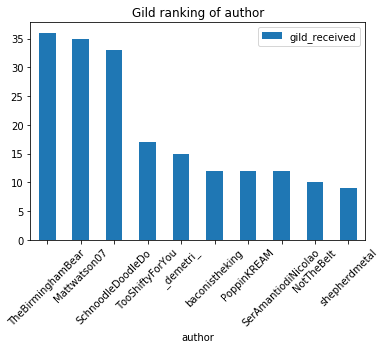

In [21]:
gild_pd.plot(kind='bar',x='author',y='gild_received')
plt.title('Gild ranking of author')
plt.xticks(rotation=45)

Predict subreddit based on comment (classification)

In [22]:
from pyspark.ml.classification import *
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline, Model
from pyspark.ml.feature import * # CountVectorizer, Tokenizer, RegexTokenizer, HashingTF

In [25]:
top_five_themed_subreddits = {'AskReddit','politics','nba','teenagers','gaming'}

df = rc.select('id','body','subreddit').where(col('subreddit').isin(top_five_themed_subreddits))

print ("\nThe total number of comments in the top five themed subreddits:",df.count())


The total number of comments in the top five themed subreddits: 2602191


In [26]:
#convert subreddit string to number
labelIndexer = StringIndexer(inputCol = "subreddit", outputCol = "subreddit_num")
labelCol = labelIndexer.getOutputCol()

#Convert body of comment to tokens
tokenizer = RegexTokenizer(inputCol = 'body', outputCol = 'tokens', pattern = '\W', minTokenLength = 2)

#Remove stop words from tokens
remover = StopWordsRemover(inputCol = tokenizer.getOutputCol(), outputCol = "tokens_filtered")

#Hash tokens into a feature hashed matrix
hashingTF = HashingTF(inputCol = remover.getOutputCol(), outputCol = 'features', numFeatures = 1024)

#Calculate the TF_IDF of the words, this will put let emphasis on words that appear more often
idf = IDF(inputCol = hashingTF.getOutputCol(), outputCol = "tf_idf_features")

#Train a random forest classifier
rf = RandomForestClassifier(labelCol = labelCol, featuresCol = idf.getOutputCol(), numTrees = 3)

#Steps in pipeline, tokenize, hash then model
pipeline = Pipeline(stages = [labelIndexer, tokenizer, remover, hashingTF, idf, rf])

#Split data into training and test
(train, test) = df.randomSplit([0.8, 0.2])

#Fit model
model = pipeline.fit(train)
prediction = model.transform(test)

In [28]:
evaluator = MulticlassClassificationEvaluator(labelCol = labelCol, predictionCol = "prediction", metricName = "accuracy")

accuracy = evaluator.evaluate(prediction)

print("Accuracy = %g" % accuracy)

Accuracy = 0.558603


In [67]:
sc.stop()